In [21]:
import os
import sys
import numpy as np
import neuroglancer
import matplotlib.pyplot as plt
import shutil

In [14]:
HOME = os.path.expanduser("~")
PATH = os.path.join(HOME, 'programming/pipeline_utility/src')
sys.path.append(PATH)
from lib.utilities_cvat_neuroglancer import get_structure_number, get_segment_properties, NumpyToNeuroglancer
from lib.sqlcontroller import SqlController

In [15]:
sqlController = SqlController('MD589')
resolution = sqlController.scan_run.resolution
surface_threshold = 0.8
SCALE = (10 / resolution)


In [37]:
ATLAS_PATH = '/net/birdstore/Active_Atlas_Data/data_root/atlas_data/atlasV7'
ORIGIN_PATH = os.path.join(ATLAS_PATH, 'origin')
VOLUME_PATH = os.path.join(ATLAS_PATH, 'structure')
origin_files = sorted(os.listdir(ORIGIN_PATH))
volume_files = sorted(os.listdir(VOLUME_PATH))

structure_volume_origin = {}
for volume_filename, origin_filename in zip(volume_files, origin_files):
    structure = os.path.splitext(volume_filename)[0]
    if structure not in origin_filename:
        print(structure, origin_filename)
        break

    color = get_structure_number(structure.replace('_L', '').replace('_R', ''))

    origin = np.loadtxt(os.path.join(ORIGIN_PATH, origin_filename))
    volume = np.load(os.path.join(VOLUME_PATH, volume_filename))
    
    volume = np.rot90(volume, axes=(0,1))
    volume = np.flip(volume, axis=0)
    volume[volume > 0.8] = color
    volume = volume.astype(np.uint8)
    
    structure_volume_origin[structure] = (volume, origin)
print(structure_volume_origin.keys())

dict_keys(['10N_L', '10N_R', '12N', '3N_L', '3N_R', '4N_L', '4N_R', '5N_L', '5N_R', '6N_L', '6N_R', '7N_L', '7N_R', '7n_L', '7n_R', 'AP', 'Amb_L', 'Amb_R', 'DC_L', 'DC_R', 'IC', 'LC_L', 'LC_R', 'LRt_L', 'LRt_R', 'PBG_L', 'PBG_R', 'Pn_L', 'Pn_R', 'RMC_L', 'RMC_R', 'RtTg', 'SC', 'SNC_L', 'SNC_R', 'SNR_L', 'SNR_R', 'Sp5C_L', 'Sp5C_R', 'Sp5I_L', 'Sp5I_R', 'Sp5O_L', 'Sp5O_R', 'Tz_L', 'Tz_R', 'VCA_L', 'VCA_R', 'VCP_L', 'VCP_R', 'VLL_L', 'VLL_R'])


In [38]:

x_length = 1000
y_length = 1000
z_length = 300
atlas_volume = np.zeros((x_length, y_length, z_length), dtype=np.uint32)

for structure, (volume, origin) in structure_volume_origin.items():
    x, y, z = origin
    x_start = int(x) + x_length // 2
    y_start = int(y) + y_length // 2
    z_start = int(z) // 2 + z_length // 2
    x_end = x_start + volume.shape[0]
    y_end = y_start + volume.shape[1]
    z_end = z_start + (volume.shape[2] + 1) // 2

    z_indices = [z for z in range(volume.shape[2]) if z % 2 == 0]
    volume = volume[:, :, z_indices]
    atlas_volume[x_start:x_end, y_start:y_end, z_start:z_end] += volume

In [32]:
atlas_name = 'atlasV8'
DATA_PATH = '/net/birdstore/Active_Atlas_Data/data_root'
ATLAS_PATH = os.path.join(DATA_PATH, 'atlas_data', atlas_name)
ORIGIN_PATH = os.path.join(ATLAS_PATH, 'origin')
VOLUME_PATH = os.path.join(ATLAS_PATH, 'structure')
OUTPUT_DIR = os.path.join(ATLAS_PATH, 'atlas')
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)
origin_files = sorted(os.listdir(ORIGIN_PATH))
volume_files = sorted(os.listdir(VOLUME_PATH))
sqlController = SqlController('MD589')
resolution = sqlController.scan_run.resolution
surface_threshold = 0.8
SCALE = (10 / resolution)


structure_volume_origin = {}
for volume_filename, origin_filename in zip(volume_files, origin_files):
    structure = os.path.splitext(volume_filename)[0]
    if structure not in origin_filename:
        print(structure, origin_filename)
        break
    
    try:
        color = sqlController.get_structure_color(structure)
    except:
        print('no color for', structure)
        color = 10

    origin = np.loadtxt(os.path.join(ORIGIN_PATH, origin_filename))
    volume = np.load(os.path.join(VOLUME_PATH, volume_filename))

    #volume = np.rot90(volume, axes=(0, 1))
    #volume = np.flip(volume, axis=0)
    #volume[volume > surface_threshold] = color
    #volume = volume.astype(np.uint8)

    structure_volume_origin[structure] = (volume, origin)


In [33]:
col_length = 1000
row_length = 1000
z_length = 300
atlas_volume = np.zeros(( int(row_length), int(col_length), z_length), dtype=np.uint8)
print('atlas volume shape', atlas_volume.shape)

for structure, (volume, origin) in sorted(structure_volume_origin.items()):
    print(str(structure).ljust(7),end=": ")
    x, y, z = origin
    x_start = int( round(x + col_length / 2))
    y_start = int( round(y + row_length / 2))
    z_start = int(z) // 2 + z_length // 2
    x_end = x_start + volume.shape[0]
    y_end = y_start + volume.shape[1]
    z_end = z_start + (volume.shape[2] + 1) // 2

    print('Row range',
          str(y_start).rjust(4),
          str(y_end).rjust(4),
          'col range',
          str(x_start).rjust(4),
          str(x_end).rjust(4),
          'z range',
          str(z_start).rjust(4),
          str(z_end).rjust(4),
          end=" ")


    z_indices = [z for z in range(volume.shape[2]) if z % 2 == 0]
    volume = volume[:, :, z_indices]
    #volume = np.swapaxes(volume, 0, 1)

    try:
        atlas_volume[x_start:x_end, y_start:y_end, z_start:z_end] += volume
    except ValueError as ve:
        print(ve, end=" ")

    print()


atlas volume shape (1000, 1000, 300)
10N_L  : Row range  515  575 col range  660  735 z range  138  155 
10N_R  : Row range  516  578 col range  662  741 z range  150  164 
12N    : Row range  532  588 col range  653  733 z range  140  163 
3N_L   : Row range  357  381 col range  336  377 z range  142  154 
3N_R   : Row range  338  428 col range  333  392 z range  146  165 
4N_L   : Row range  363  378 col range  372  384 z range  142  147 
4N_R   : Row range  349  431 col range  368  397 z range  151  164 
5N_L   : Row range  466  523 col range  423  471 z range  111  124 
5N_R   : Row range  461  524 col range  418  473 z range  177  189 
6N_L   : Row range  478  492 col range  486  502 z range  138  145 
6N_R   : Row range  470  556 col range  479  505 z range  153  169 
7N_L   : Row range  578  620 col range  492  558 z range  109  135 
7N_R   : Row range  570  623 col range  485  561 z range  166  191 
7n_L   : Row range  494  583 col range  456  534 z range  109  139 
7n_R   : Ro

(1000, 1000, 300) uint32


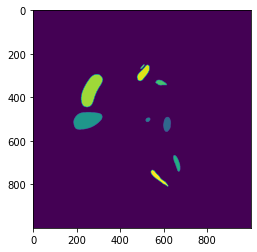

In [40]:
#arr = np.swapaxes(atlas_volume, 0, 1)
arr = atlas_volume.copy()
print(arr.shape, arr.dtype)
plt.imshow(arr[:,:,100])

Text(0.5, 1.0, ' uint32')

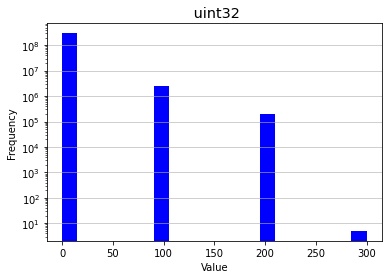

In [40]:
flat = arr.flatten()
fig = plt.figure()
plt.rcParams['figure.figsize'] = [10, 6]
plt.hist(flat, bins=20, color='b')
plt.style.use('ggplot')
plt.yscale('log')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title(f' {arr.dtype}')

In [31]:
%%time
OUTPUT_DIR = '/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/structures/atlasV7'

ng = NumpyToNeuroglancer(animal = 'Atlas' , volume = atlas_volume, scales = [10000, 10000, 20000],layer_type = 'segmentation', data_type = atlas_volume.dtype)
ng.preview()


A new layer named segmentation_[10000, 10000, 20000] is added to:
http://127.0.0.1:40369/v/c4af47fd9335343869994020dd1df41bd9df4597/
CPU times: user 0 ns, sys: 4.01 ms, total: 4.01 ms
Wall time: 7.66 ms


In [11]:
ng.init_precomputed(OUTPUT_DIR, volume_size=atlas_volume.shape)
ng.add_segment_properties(get_segment_properties())
ng.add_downsampled_volumes()
ng.add_segmentation_mesh()

Tasks:   0%|          | 0/5 [00:00<?, ?it/s]

Volume Bounds:  Bbox([0, 0, 0],[1000, 1000, 300], dtype=int32)
Selected ROI:   Bbox([0, 0, 0],[1000, 1000, 300], dtype=int32)



Tasks:   0%|          | 0/5 [00:00<?, ?it/s] ?it/s]


EmptyVolumeException: 10000_10000_20000/0-256_0-256_0-128



Downloading:   0%|          | 0/16 [00:00<?, ?it/s]

In [6]:
with open('atlasV7.npy', 'wb') as file:
    np.save(file, atlasV7_volume)